<a href="https://colab.research.google.com/github/sayan8856/MLDS/blob/main/Route%20Optimization2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install folium
%pip install plotly.express
%pip install osmnx
%pip install networkx
%pip install ortools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.3 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!

In [4]:
city = "London"
dtf=pd.read_csv('data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 216


,id,City,Street Address,y,x
0,0,London,265 Wharncliffe Rd North,42.99,-81.26
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22
2,2,London,631 Commissioners Road East,42.96,-81.23


In [5]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [ 42.99 -81.26]


In [6]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row:
    folium.CircleMarker(
        location=[row["y"], row["x"]],
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map

/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


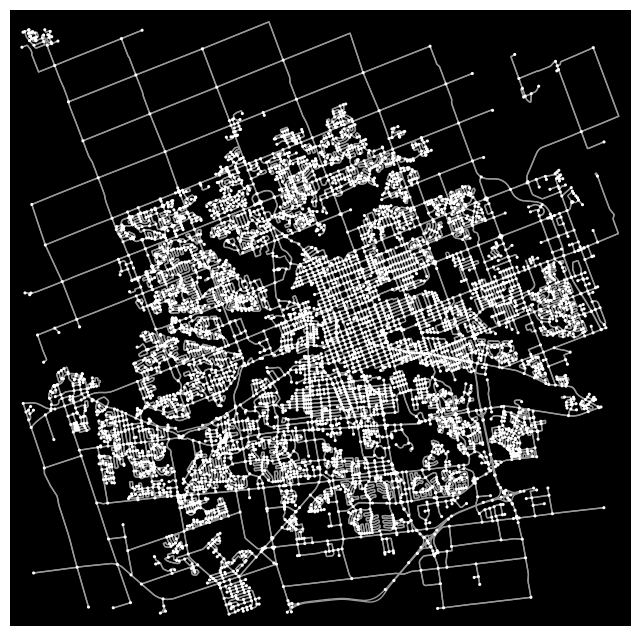

In [7]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [8]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

<ipython-input-8-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
<ipython-input-8-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
<ipython-input-8-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["nod

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


In [9]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.0,544.5,340.3,593.2,498.4,396.9,112.9,393.5,549.7,88.7,512.2,429.3,228.0,185.1,543.1,221.9,480.6,475.8,1033.4,1026.0
324811692,586.0,0.0,211.0,1098.3,948.4,705.9,458.7,873.3,733.6,492.1,400.4,885.2,670.2,401.9,665.3,767.2,109.9,980.9,1307.8,773.9
11756886360,375.0,209.9,0.0,911.9,737.4,573.3,247.7,662.3,547.2,281.1,402.7,698.8,459.2,190.9,549.0,574.5,229.6,794.5,1190.1,909.3
252974916,592.3,1096.0,914.5,0.0,428.2,838.7,699.0,323.3,479.9,663.5,725.3,354.4,498.6,765.2,1063.6,431.2,1015.1,172.8,1232.7,977.7
302754873,498.3,948.2,738.3,429.0,0.0,461.5,573.0,107.1,888.7,511.6,864.1,758.0,346.7,563.9,686.4,393.3,952.0,311.6,855.5,1384.8


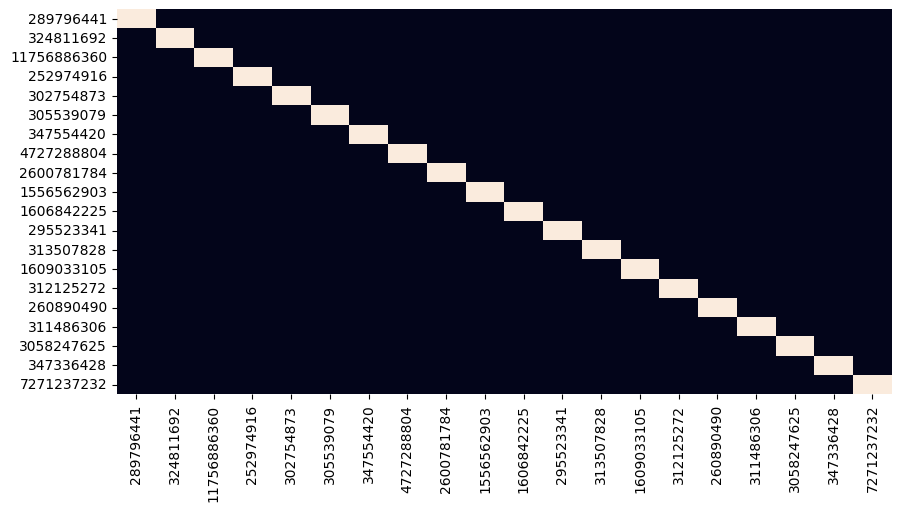

In [10]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x:
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else
          (0 if x!=0 else 1)) )

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()


In [11]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0,545,340,593,498,397,113,394,550,89,512,429,228,185,543,222,481,476,1033,1026
324811692,586,0,211,1098,948,706,459,873,734,492,400,885,670,402,665,767,110,981,1308,774
11756886360,375,210,0,912,737,573,248,662,547,281,403,699,459,191,549,574,230,794,1190,909
252974916,592,1096,914,0,428,839,699,323,480,664,725,354,499,765,1064,431,1015,173,1233,978
302754873,498,948,738,429,0,461,573,107,889,512,864,758,347,564,686,393,952,312,856,1385
305539079,397,637,576,840,464,0,433,518,888,371,864,758,388,402,298,550,730,722,685,1348
347554420,144,456,246,708,572,432,0,467,516,95,479,515,264,92,486,343,401,590,1066,993
4727288804,391,871,661,322,107,517,466,0,782,405,757,651,240,506,742,286,845,204,911,1278
2600781784,552,731,549,477,885,885,519,781,0,604,360,179,716,575,995,561,650,630,1522,626
1556562903,161,490,280,666,510,371,95,405,599,0,561,532,202,125,483,328,474,548,1008,1075


In [12]:
drivers = 1
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [13]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [14]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [15]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))

    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

route for driver:
[0, 6, 9, 13, 2, 1, 16, 10, 8, 11, 3, 17, 7, 4, 12, 15, 5, 14, 18, 19]
Total distance:6.6km
Nodes visited: 20


In [16]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 347554420, 1556562903, 1609033105, 11756886360, 324811692, 311486306, 1606842225, 2600781784, 295523341, 252974916, 3058247625, 4727288804, 302754873, 313507828, 260890490, 305539079, 312125272, 347336428, 7271237232]


In [17]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)

map

<ipython-input-17-eb8784d65643>:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
<ipython-input-17-eb8784d65643>:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
<ipython-inp

In [18]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], []

        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)),
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))

    df=df.reset_index().rename(columns={"index":"id"})
    return df


In [19]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [20]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig